# Coding Assignment - 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import linear_model as lm

np.random.seed(100)


## Part 1: Generate Data

Generate the 20 centers, 10 for each group.

<span style="color:red">To Be Done : </span> Make the Centers created based on the formula provided in the problem statement

In [3]:
csize = 10      
p = 2      
s = 1;      # sd for generating the centers within each class                    
m1 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[0, 1]] * csize)])

Generate training & test data.

In [4]:
n = 100
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = n)
id0 = np.random.randint(csize, size = n)

# sd for generating data  
s = np.sqrt(float(1)/5) 

traindata = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])
ytrain = np.concatenate(([1]*n, [0]*n))

Visulization

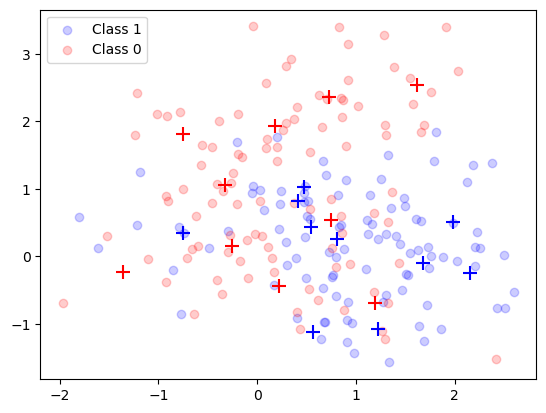

In [5]:
plt.scatter(traindata[:n, 0], traindata[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n:, 0], traindata[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()